# Optimization method : Exterior Penalty Function - Augmented Lagrangian (Section 5.4.1 Martins, J. and Ning, A.)

Augmented Lagrangian function for equality constraints is

$\hat{f}(x; \lambda, \mu) = f(x) + \sum^{n_h}_{j=1} \lambda_j h_j (x) + \frac{\mu}{2} \sum^{n_h}_{j=1}h_j(x)^2$

The optimality conditions for the augmented Lagrangian:

$\nabla_x \hat{f} (x; \lambda, \mu) = \nabla f(x) + \sum^{n_h}_{j=1} (\lambda_j + \mu h_j(x)) \nabla h_j = 0$

The optimality conditions for the actual Lagrangian:

$\nabla_x \mathfrak{L}(x^*, \lambda^*) = \nabla f(x^*) + \sum^{n_h}_{j=1} \lambda_j^* \nabla h_j(x^*) = 0$

Comparing these two conditions

$\lambda^*_j \approx \lambda_j + \mu h_j$

Therefore, the update of the vector of Lagrange multipliers $\mathbf{\lambda}_{k+1}$ is based on the current estimate of the Lagrange multipliers $\mathbf{\lambda}_k$ and constraint values $\mathbf{h}(\mathbf{x}_k)$ using

$\lambda_{k+1} = \lambda_k + \mu_k h(x_k)$

This approach is an improvement on the plain quadratic penalty because updating the Lagrange multiplier estimates at each iteration allows for more accurate solutions without increasing $\mu$ as much. The quadratic penalty increases $\mu$ in the denominator to drive the constraints to zero ($h_j \approx \frac{\lambda_j^*}{\mu}$), while the augmented Lagrangian also controls the numerator through the Lagrange multiplier estimate. If the estimate is reasonably close to the true Lagrange multiplier, then the numerator becomes small for modest values of $\mu$. Thus, the augmented Lagrangian can provide a good solution for $x^*$ while avoiding the ill-conditioning issues of the quadratic penalty.

$h_j \approx \frac{1}{\mu} (\lambda^*_j - \lambda_j)$

One well-known approach for handling inequality constraints using the augmented Lagrangian approach is given by

$\hat{f}(x; \mu) = f(x) + \lambda^T \overline{g}(x) + \frac{\mu}{2} \| \overline{g}(x) \|^2_2$

where

$\overline{g}(x) \equiv \left\{\begin{array}{ll} h_j(x) & \text{for equality constraints} \\ g_j(x) & \text{if } g_j \geq -\lambda_j/\mu \\ -\lambda_j/\mu & \text{otherwise.} \end{array}\right.$

## For the unconstrained search: conjugated gradient + interval reduction method

1) Step size: Golden Search Method, employing the function "minimize_scalar" from scipy.optimize

2) Search direction : Conjugated Gradient, $\mathbf{d}_{(t)} = -\nabla_{\mathbf{x}} f_{(t)} + \beta_{(t)}\mathbf{d}_{(t-1)}$, onde $\beta_{(t)}=\left[\frac{||\nabla_{\mathbf{x}} f_{(t)}||}{||\nabla_{\mathbf{x}} f_{(t-1)}||}\right]^2$ 

The first step consists in defining the algorithms parameters, such as initial point $\mathbf{x}_{(0)}$, $\alpha_{(t)}$ and convergence tolerance constant $\epsilon_{\nabla}$, as well as the function to be minimized and its gradient evaluation:



# Import necessary libraries

In [1]:
import numpy as np
from scipy.optimize import minimize
from CG_GS import CG_GS, f_alpha
from methods import get_values, methods
from problems import problems
from check_convergence import check_convergence
%matplotlib widget

# Set parameters (user has to define)

#### Problem and initial guess

In [2]:
# 1 = Example 5.4, P. 170 (Joaquim R. R. A. Martins, Andrew Ning - Engineering Design Optimization (2021))
# 2 = Example 4.27, P. 122 (Jasbir S. Arora - Introduction to optimum design (2004))
# 3 = Example 4.31, P. 134 (Jasbir S. Arora - Introduction to optimum design (2004))
# 4 = Example 5.6, P. 183 (Jasbir S. Arora - Introduction to optimum design (2004))
problem = 4

# Initial guess
x = np.array([0.0, 0.0])

#### Define the method of optimization

In [3]:
# 1 = Quadratic penalty
# 2 = Augmented Lagrangian
method = 2

#### Initial value for penalization ($\mu$) and rate of increase ($\rho$)

In [4]:
mu = 0.5
rho = 1.1

#### Stopping criterias for the exterior penalty method

In [5]:
it_max = 10 # Maximum number of iterations
epsilon1 = 1e-5 # Magnitude of the penalty terms
epsilon2 = 1e-5 # Change in value of the penalized objective function

#### Upper bound ($\alpha$) for the Golden Search Algorithm and convergence of Conjugate Gradient

In [6]:
alpha0 = 1.0
TolG = 1e-5

# Get the problem and method

In [7]:
obj_fun, eq_cons, ineq_cons = problems(problem)

In [8]:
# Set initial Lagrange multipliers
f, _, h, _, g, _ = get_values(np.array([0, 0]), obj_fun, eq_cons, ineq_cons)

lambda_eq = np.zeros((h.size))
lambda_ineq = np.zeros((g.size))

# Get the phi function of the chosen method
phi, method = methods(method, obj_fun, eq_cons, ineq_cons)

# Optimize

In [9]:
# Initialize variables
k, cost_f, cost_g, stop, x0 = 0, 0, 0, False, x
f = obj_fun['fun'](x)
f_old = np.copy(f)
points = np.array([x])
values = np.array([f])

while not stop:
    # Conjugate gradient + Golden search method
    xt, f, df, t, xs, fs = CG_GS(x, alpha0, TolG, phi, f_alpha, mu, lambda_eq, lambda_ineq)
        
    # Check convergence
    f_opt, _, h, dh, g, dg = get_values(xt, obj_fun, eq_cons, ineq_cons)
    stop = check_convergence(k, f_old, f, f_opt, it_max, epsilon1, epsilon2)
    k = k + 1
    f_old = f
    
    p, dp = phi(x, args=([mu, lambda_eq, lambda_ineq]))
    
    # Append points for plots
    # points = np.concatenate((points, xs))
    # values = np.concatenate((values, fs))
    points = np.concatenate((points, np.array([xt])))
    values = np.concatenate((values, np.array([f_opt])))
        
    # Update Lagrange multiplier, penalty parameter and starting point
    lambda_eq = lambda_eq + mu*h
    lambda_ineq = lambda_ineq + mu*g
    mu = mu*rho
    x = xt
    
    # Update cost
    cost_f += t
    cost_g += t

Stopped due to a small change in value of the              penalized objective function


## Print results

In [10]:
fopt, dfopt, hopt, dhopt, gopt, dgopt = get_values(x, obj_fun, eq_cons, ineq_cons)

print(f'Initial point: {x0}')
print(f'Optimum found with {method} method, for problem {problem}: {xt}')
print(f'Objective function value at the optimum: {fopt}')
print(f'Transformed function value at the optimum: {p}')
print(f'Inequality constraints and inequality multipliers at the optimum: {gopt}; {lambda_ineq}')
print(f'Equality constraints and equality multipliers at the optimum: {hopt}; {lambda_eq}')
print(f'Number of times that the objective function and constraints were evaluated, respectively: {cost_f}, {cost_g}')
print(f'Number of iterations of the External penalty method: {k}')

Initial point: [0. 0.]
Optimum found with Augmented Lagrangian method, for problem 4: [1.33323337 1.33323337]
Objective function value at the optimum: [0.22208896]
Transformed function value at the optimum: [0.22222334]
Inequality constraints and inequality multipliers at the optimum: [0.00029989 0.00029989]; [0.22215558 0.22215558]
Equality constraints and equality multipliers at the optimum: []; []
Number of times that the objective function and constraints were evaluated, respectively: 52, 52
Number of iterations of the External penalty method: 6


## Plot

In [11]:
from plot_descent_penalty import plot_2d_contour, plot_3d_surface

In [12]:
all_x = np.array(points)
all_x = np.reshape(all_x, ( int(all_x.size/2), 2 ))

all_f = np.array(values)
all_f = np.reshape(all_f, (all_f.size))

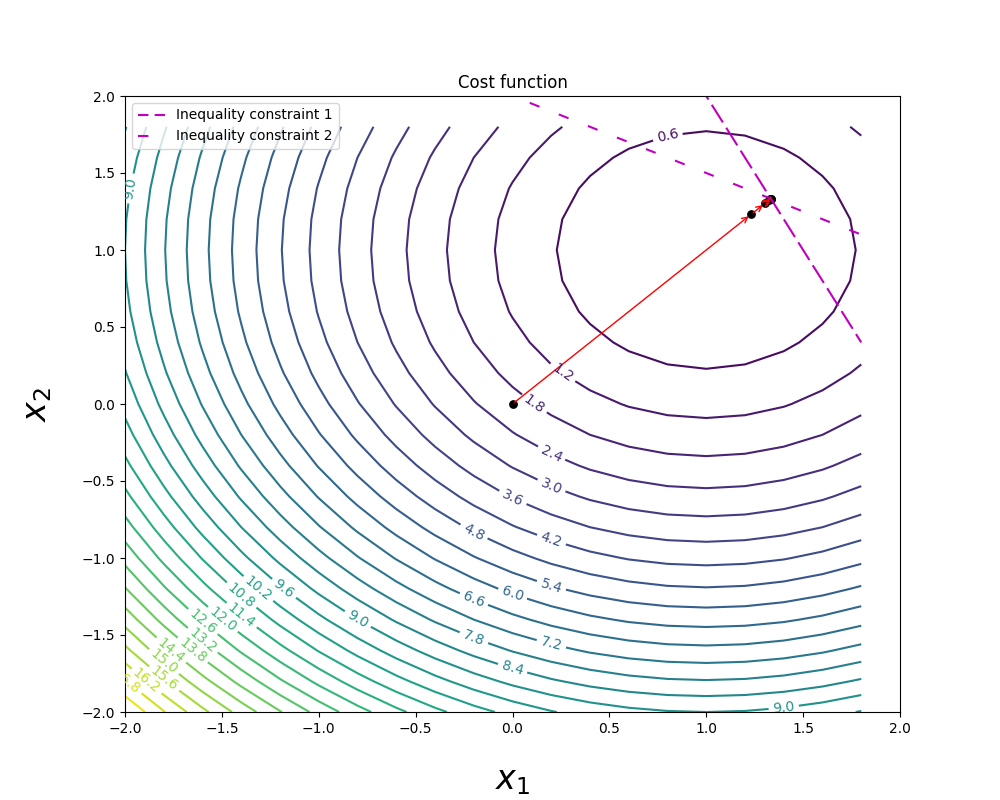

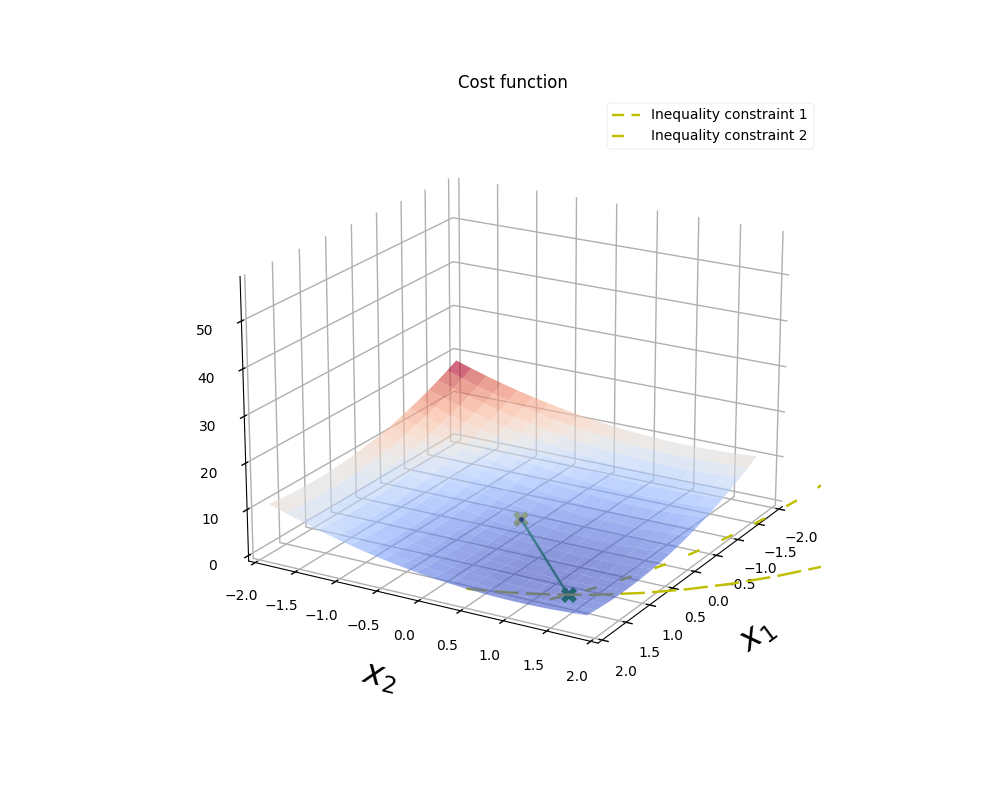

In [13]:
plot_2d_contour(all_x, obj_fun, eq_cons, ineq_cons, plot_h=True, plot_g=True, high_quality=False)
plot_3d_surface(all_x, all_f, obj_fun, eq_cons, ineq_cons, plot_h=True, plot_g=True, high_quality=False)

# Optimize using SLSQP from scipy

In [14]:
from scipy.optimize import Bounds

bounds = Bounds([-5, -5], [5, 5])

constraints = []
if eq_cons['fun'](np.array([0, 0])).size > 0:
    constraints.append(eq_cons)

if ineq_cons['fun'](np.array([0, 0])).size > 0:
    constraints.append(ineq_cons)

res = minimize(obj_fun['fun'], x0, method='SLSQP', jac=obj_fun['jac'],
               constraints=constraints, options={'ftol': TolG, 'disp': True},
               bounds=bounds)

print(f'Optimum found with SLSQP method, for problem {problem}: {res.x}')
print(f'Objective function value at the optimum: {res.fun}')
print(f'Number of times that the f_obj function was evaluated: {res.nfev}')

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.0
            Iterations: 3
            Function evaluations: 3
            Gradient evaluations: 3
Optimum found with SLSQP method, for problem 4: [1. 1.]
Objective function value at the optimum: 0.0
Number of times that the f_obj function was evaluated: 3
